In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geocoder
import requests
import category_encoders as ce
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.grid_search import GridSearchCV  
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pickle
import sys
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import RobustScaler
from sklearn.feature_extraction.text import CountVectorizer
import itertools
from livestats import livestats
import math

import re, sys, math, random, csv, types, networkx as nx

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

%matplotlib inline


pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

/Users/manu/anaconda3/envs/gdal2/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/manu/anaconda3/envs/gdal2/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
DATA_FOLDER = os.path.join('..', 'data')

In [3]:
with open(os.path.join(DATA_FOLDER, 'cleaned_data.pickle'), 'rb') as handle:
    df_claims = pickle.load(handle)

In [4]:
with open(os.path.join(DATA_FOLDER, 'xgboost.pickle'), 'rb') as handle:
    xgboost_pickle = pickle.load(handle)

In [5]:
xgboost_pickle

{'features': Index(['department_0', 'department_1', 'department_2', 'department_3',
        'department_4', 'department_5', 'department_6', 'department_7',
        'department_8', 'department_9',
        ...
        'perfrm_qcdr_ep_giqic4_1', 'perfrm_qcdr_ep_giqic9_1',
        'patnt_cahps_grp_1', 'patnt_cahps_grp_10', 'patnt_cahps_grp_12',
        'patnt_cahps_grp_2', 'patnt_cahps_grp_3', 'patnt_cahps_grp_5',
        'patnt_cahps_grp_8', 'patnt_cahps_grp_9'],
       dtype='object', length=198),
 'xgboost_model': GridSearchCV(cv=5, error_score='raise',
        estimator=Pipeline(memory=None,
      steps=[('sex', BinaryEncoder(cols=['sex'], drop_invariant=False, handle_unknown='impute',
        impute_missing=True, return_df=True, verbose=0)), ('includes_drug', BinaryEncoder(cols=['includes_drug'], drop_invariant=False,
        handle_unknown='impute', impute_missing=True, return_df=True,
       ...g:linear', reg_alpha=0, reg_lambda=1,
        scale_pos_weight=1, seed=0, silent=True, su

In [6]:
def get_train_test(df, test_size=0.33, seed=42):
    X = df.drop(['npi', 'hcpcs_code', 'avg_medicare_payment_amt', 'overcharge_ratio'], axis=1, inplace=False)
    Y = df['overcharge_ratio']
    X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, test_size=test_size, random_state=seed)

    return (X_Train, X_Test, Y_Train, Y_Test)

In [7]:
X_Train, X_Test, Y_Train, Y_Test = get_train_test(df_claims)

In [8]:
with open(os.path.join(DATA_FOLDER, 'code_cluster_diam.pickle'), 'rb') as handle:
    df_code_cluster = pickle.load(handle)

In [9]:
df_code_cluster['code_cluster_diam'] = df_code_cluster['code_cluster_diam'].replace(0, 0.0000001)

In [31]:
df_claims.dtypes

npi                                                                   int64
sex                                                                  object
department                                                           object
is_participant                                                       object
facility_type                                                        object
hcpcs_code                                                           object
includes_drug                                                        object
no_service                                                          float64
no_medicare_benef                                                   float64
no_distinct_medicare_benef_per_day                                  float64
avg_medicare_allowed_amount                                         float64
avg_submitted_charge_amt                                            float64
avg_medicare_payment_amt                                            float64
overcharge_r

In [72]:
with open(os.path.join(DATA_FOLDER, 'raw_data.pickle'), 'rb') as handle:
    df_raw_claims = pickle.load(handle)

In [163]:
df_raw_claims[df_raw_claims['National Provider Identifier'] == 1437398187][['Provider Type', 'HCPCS Description']].to_csv(sys.stdout)

,Provider Type,HCPCS Description
46630,Anesthesiology,"Critical care delivery critically ill or injured patient, first 30-74 minutes"
2564509,Anesthesiology,Anesthesia for procedure on gastrointestinal tract using an endoscope
4557492,Anesthesiology,Anesthesia for procedure on lower intestine using an endoscope
4883632,Anesthesiology,"Insertion of arterial catheter for blood sampling or infusion, accessed through the skin"
6506873,Anesthesiology,Critical care delivery critically ill or injured patient


In [159]:
df_raw_claims[df_raw_claims['National Provider Identifier'] ==1366602666][['Provider Type', 'HCPCS Description']].to_csv(sys.stdout)

,Provider Type,HCPCS Description
1293578,General Surgery,Ultrasound of head and neck
1559934,General Surgery,"Established patient office or other outpatient visit, typically 15 minutes"
3364851,General Surgery,"New patient office or other outpatient visit, typically 30 minutes"
5167923,General Surgery,Removal or exploration of parathyroid glands
6899632,General Surgery,"Established patient office or other outpatient visit, typically 15 minutes"
7205008,General Surgery,Nuclear medicine study of radioactive material distribution at tumor location


In [161]:
df_raw_claims[df_raw_claims['National Provider Identifier'] == 1154364826][['Provider Type', 'HCPCS Description']].to_csv(sys.stdout)

,Provider Type,HCPCS Description
148063,Anesthesiology,Anesthesia for X-ray procedure (accessed through the skin) on spine and spinal cord
2892629,Anesthesiology,Routine EKG using at least 12 leads including interpretation and report
3702662,Anesthesiology,"Anesthesia for nerve block and injection procedure, prone position"
4355175,Anesthesiology,"New patient office or other outpatient visit, typically 30 minutes"
4369186,Anesthesiology,"Anesthesia for nerve block and injection procedure, prone position"
6313282,Anesthesiology,"Established patient office or other outpatient visit, typically 15 minutes"
8488958,Anesthesiology,"Blood test, comprehensive group of blood chemicals"
8689844,Anesthesiology,Anesthesia for procedure on salivary gland with biopsy


In [7]:
1-np.mean(df_claims['overcharge_ratio'])

0.31492649101683434

In [203]:
df_dept_cluster_input = df_cluster_input[['npi', 'department', 'no_service', 'no_medicare_benef', 'no_distinct_medicare_benef_per_day', 'avg_medicare_allowed_amount', 'avg_submitted_charge_amt', 'hcpcs_code', 'overcharge_ratio', 'no_medicare_benef']].loc[df_cluster_input['department'] == 'Infectious Disease']
npis = df_dept_cluster_input[['npi', 'hcpcs_code', 'overcharge_ratio', 'no_medicare_benef', 'avg_submitted_charge_amt' ]]
df_dept_cluster_input.drop(['npi', 'hcpcs_code', 'department', 'overcharge_ratio'], axis=1, inplace=True)


In [204]:
db = DBSCAN(eps=0.5, min_samples=15, algorithm='ball_tree').fit(df_dept_cluster_input)

In [207]:
df_dept_cluster_input.columns

Index(['no_service', 'no_medicare_benef', 'no_distinct_medicare_benef_per_day',
       'avg_medicare_allowed_amount', 'avg_submitted_charge_amt',
       'no_medicare_benef'],
      dtype='object')

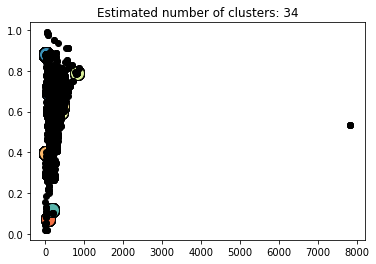

In [206]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)
    
    xy = npis[['overcharge_ratio', 'avg_submitted_charge_amt']][class_member_mask & core_samples_mask]
    plt.plot(xy['avg_submitted_charge_amt'], xy['overcharge_ratio'], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = npis[['overcharge_ratio', 'avg_submitted_charge_amt']][class_member_mask & ~core_samples_mask]
    plt.plot(xy['avg_submitted_charge_amt'], xy['overcharge_ratio'], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()


In [137]:
len(set(labels)) - (1 if -1 in labels else 0)

34

In [14]:
with open(os.path.join(DATA_FOLDER, 'robust_lreg.pickle'), 'rb') as handle:
    lreg = pickle.load(handle)

In [72]:
lreg['features'] = cols_transformed

In [42]:
with open(os.path.join(DATA_FOLDER, 'xgboost.pickle'), 'rb') as handle:
    rforest = pickle.load(handle)

In [10]:
rms = np.sqrt(mean_squared_error(Y_Test, xgboost_pickle['xgboost_preds']))

In [19]:
xgboost_pickle

{'features': Index(['department_0', 'department_1', 'department_2', 'department_3',
        'department_4', 'department_5', 'department_6', 'department_7',
        'department_8', 'department_9',
        ...
        'perfrm_qcdr_ep_giqic4_1', 'perfrm_qcdr_ep_giqic9_1',
        'patnt_cahps_grp_1', 'patnt_cahps_grp_10', 'patnt_cahps_grp_12',
        'patnt_cahps_grp_2', 'patnt_cahps_grp_3', 'patnt_cahps_grp_5',
        'patnt_cahps_grp_8', 'patnt_cahps_grp_9'],
       dtype='object', length=198),
 'xgboost_model': GridSearchCV(cv=5, error_score='raise',
        estimator=Pipeline(memory=None,
      steps=[('sex', BinaryEncoder(cols=['sex'], drop_invariant=False, handle_unknown='impute',
        impute_missing=True, return_df=True, verbose=0)), ('includes_drug', BinaryEncoder(cols=['includes_drug'], drop_invariant=False,
        handle_unknown='impute', impute_missing=True, return_df=True,
       ...g:linear', reg_alpha=0, reg_lambda=1,
        scale_pos_weight=1, seed=0, silent=True, su

In [45]:
rforest['xgboost_model'].best_estimator_.named_steps['xgboost'].booster().get_score(importance_type='weight')

{'avg_submitted_charge_amt': 3081,
 'committed_to_heart_health_through_the_million_hearts_initiative__0': 46,
 'department_0': 39,
 'department_1': 33,
 'department_10': 60,
 'department_11': 16,
 'department_12': 21,
 'department_13': 9,
 'department_14': 34,
 'department_15': 10,
 'department_16': 7,
 'department_17': 39,
 'department_18': 64,
 'department_19': 21,
 'department_2': 74,
 'department_20': 81,
 'department_21': 36,
 'department_22': 21,
 'department_23': 50,
 'department_24': 84,
 'department_25': 24,
 'department_26': 49,
 'department_27': 38,
 'department_28': 14,
 'department_29': 24,
 'department_3': 27,
 'department_30': 34,
 'department_31': 46,
 'department_32': 16,
 'department_33': 16,
 'department_34': 25,
 'department_35': 22,
 'department_36': 29,
 'department_37': 28,
 'department_38': 11,
 'department_39': 30,
 'department_4': 56,
 'department_40': 10,
 'department_41': 38,
 'department_42': 24,
 'department_43': 8,
 'department_44': 18,
 'department_45': 

In [33]:
xgboost_pickle['xgboost_model'].best_params_

{'xgboost__colsample_bytree': 0.6,
 'xgboost__gamma': 0.15,
 'xgboost__learning_rate': 0.2,
 'xgboost__max_depth': 10,
 'xgboost__min_child_weight': 0.05,
 'xgboost__subsample': 0.6}

In [43]:
correlation = np.corrcoef(Y_Test, rforest['xgboost_preds'])[0,1]

In [40]:
xgboost_pickle['xgboost_model'].best_estimator_

AttributeError: 'Pipeline' object has no attribute 'booster'

In [30]:
correlation = np.corrcoef(Y_Train, lreg['lreg_preds'])[0,1]

ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [44]:
correlation**2

0.67315100096724423

In [20]:
lreg['lreg_model'].support_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,

In [18]:
np.sqrt(mean_squared_error(Y_Test, rforest['rforest_preds']))

KeyError: 'rforest_preds'

In [3]:
def add_tag_to_score_colnames(id_col, df, scoretag):
    cols = [id_col]
    for col in df.columns:
        if col != id_col:
            cols.append(scoretag + '_' + col)
    df.columns = cols

In [4]:
def pythonize_colnames(df):
    df.columns = list(map(lambda each:each.replace(" ", "_").lower(), df.columns))

In [5]:
df_physician_info = pd.read_csv(os.path.join(DATA_FOLDER, 'Physician_Compare_National_Downloadable_File.csv'))

/Users/manu/anaconda3/envs/gdal2/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (15,25,26,27,28,29,30,31,32,33,34,36,40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
df_physician_info = df_physician_info.loc[df_physician_info['State'] == 'IL']

In [8]:
pythonize_colnames(df_physician_info)

In [9]:
df_performance_scores = pd.read_csv(os.path.join(DATA_FOLDER, 'Physician_Compare_2015_Individual_EP_Public_Reporting___Performance_Scores.csv'))

In [10]:
df_performance_scores.columns

Index(['NPI', 'PAC ID', 'Last Name', 'First Name', 'Measure Identifier',
       'Measure Title', 'Inverse Measure', 'Measure Performance Rate',
       'Reporting Mechanism', 'Reported on PC Live Site'],
      dtype='object')

In [18]:
df_performance_scores = df_performance_scores[['NPI', 'Measure Identifier','Measure Performance Rate']]

KeyError: "['NPI' 'Measure Identifier' 'Measure Performance Rate'] not in index"

In [12]:
df_performance_scores.columns = ['npi', 'measure','score']

In [13]:
df_performance_scores = df_performance_scores.pivot(index='npi', columns='measure', values='score').reset_index()

In [14]:
df_performance_scores = df_performance_scores.dropna(axis=1, how='all')

In [15]:
add_tag_to_score_colnames('npi', df_performance_scores, 'perfrm')

In [16]:
df_performance_scores = df_performance_scores.apply(pd.to_numeric, errors='ignore')

In [17]:
df_performance_scores = df_performance_scores[df_performance_scores['npi'].isin(list(df_physician_info.npi.unique()))]

In [19]:
df_patient_scores = pd.read_csv(os.path.join(DATA_FOLDER, 'Physician_Compare_2015_Group_Public_Reporting_-_Patient_Experience.csv'))

In [20]:
df_patient_scores = df_patient_scores[['Group PAC ID','Measure Identifier', 
       'Measure Performance Rate']]
df_patient_scores.columns = ['group_practice_pac_id','measure', 'score']
df_patient_scores = df_patient_scores.pivot(index='group_practice_pac_id', columns='measure', values='score').reset_index()

In [21]:
df_patient_scores = df_patient_scores[df_patient_scores['group_practice_pac_id'].isin(list(df_physician_info['group_practice_pac_id'].unique()))]

In [22]:
df_patient_scores = df_patient_scores.apply(pd.to_numeric, errors='ignore')

In [23]:
df_patient_scores = df_patient_scores.dropna(axis=1, how='all')

In [24]:
df_patient_scores.dtypes

measure
group_practice_pac_id      int64
CAHPS_GRP_1              float64
CAHPS_GRP_10             float64
CAHPS_GRP_12             float64
CAHPS_GRP_2              float64
CAHPS_GRP_3              float64
CAHPS_GRP_5              float64
CAHPS_GRP_8              float64
CAHPS_GRP_9              float64
dtype: object

In [25]:
add_tag_to_score_colnames('group_practice_pac_id', df_patient_scores, 'patnt')

In [26]:
df_physician_info = pd.merge(pd.merge(df_physician_info, df_performance_scores , on='npi', how='left'), df_patient_scores, on='group_practice_pac_id', how='left')

In [27]:
df_physician_info = df_physician_info.dropna(axis=1, how='all')

In [28]:
df_physician_info.shape

(92716, 147)

In [9]:
df_claims = pd.read_csv(os.path.join(DATA_FOLDER, 'Medicare_Provider_Utilization_and_Payment_Data__Physician_and_Other_Supplier_PUF_CY2015.csv'))

/Users/manu/anaconda3/envs/gdal2/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [17]:
df_claims['name'] = df_claims['First Name of the Provider'] +  ' ' + df_claims['Last Name/Organization Name of the Provider']

In [18]:
    with open(os.path.join(DATA_FOLDER, 'raw_data.pickle'), 'wb') as handle:
        pickle.dump(df_claims, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [30]:
df_claims = df_claims[df_claims['National Provider Identifier'].isin(list(df_physician_info['npi'].unique()))]

In [31]:
df_claims.columns

Index(['National Provider Identifier',
       'Last Name/Organization Name of the Provider',
       'First Name of the Provider', 'Middle Initial of the Provider',
       'Credentials of the Provider', 'Gender of the Provider',
       'Entity Type of the Provider', 'Street Address 1 of the Provider',
       'Street Address 2 of the Provider', 'City of the Provider',
       'Zip Code of the Provider', 'State Code of the Provider',
       'Country Code of the Provider', 'Provider Type',
       'Medicare Participation Indicator', 'Place of Service', 'HCPCS Code',
       'HCPCS Description', 'HCPCS Drug Indicator', 'Number of Services',
       'Number of Medicare Beneficiaries',
       'Number of Distinct Medicare Beneficiary/Per Day Services',
       'Average Medicare Allowed Amount', 'Average Submitted Charge Amount',
       'Average Medicare Payment Amount',
       'Average Medicare Standardized Amount'],
      dtype='object')

In [32]:
df_claims = df_claims[['National Provider Identifier', 'Gender of the Provider', 'Provider Type', 'Medicare Participation Indicator', 'Place of Service', 'HCPCS Code', 'HCPCS Drug Indicator', 'Number of Services', 'Number of Medicare Beneficiaries', 'Number of Distinct Medicare Beneficiary/Per Day Services', 'Average Medicare Allowed Amount', 'Average Submitted Charge Amount', 'Average Medicare Payment Amount']]

In [33]:
df_claims.columns = ['npi', 'sex', 'department', 'is_participant', 'facility_type', 'hcpcs_code', 'includes_drug', 'no_service', 'no_medicare_benef', 'no_distinct_medicare_benef_per_day', 'avg_medicare_allowed_amount', 'avg_submitted_charge_amt', 'avg_medicare_payment_amt']

In [34]:
df_claims = df_claims.apply(pd.to_numeric, errors='ignore')

In [35]:
df_claims = pd.merge(df_claims, df_physician_info , on='npi', how='left')

In [38]:
pythonize_colnames(df_claims)

In [40]:
df_claims.drop(['pac_id', 'professional_enrollment_id', 'last_name', 'first_name', 'middle_name', 'suffix', 'gender', 'credential', 'medical_school_name', 'primary_specialty', 'secondary_specialty_1', 'secondary_specialty_2', 'secondary_specialty_3', 'secondary_specialty_4', 'all_secondary_specialties', 'organization_legal_name', 'group_practice_pac_id', 'line_1_street_address', 'line_2_street_address', 'marker_of_address_line_2_suppression', 'city', 'state', 'zip_code', 'phone_number', 'hospital_affiliation_ccn_1', 'hospital_affiliation_lbn_1', 'hospital_affiliation_ccn_2', 'hospital_affiliation_lbn_2', 'hospital_affiliation_ccn_3', 'hospital_affiliation_lbn_3', 'hospital_affiliation_ccn_4', 'hospital_affiliation_lbn_4', 'hospital_affiliation_ccn_5', 'hospital_affiliation_lbn_5',], axis=1, inplace=True)

In [41]:
df_claims['overcharge_ratio'] = 1 - df_claims['avg_medicare_payment_amt'] / df_claims['avg_submitted_charge_amt']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x26b744898>]], dtype=object)

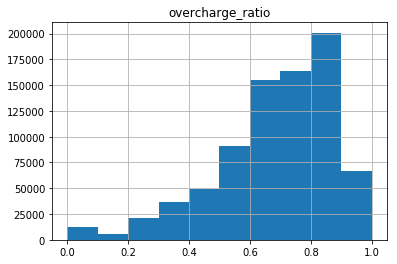

In [159]:
df_claims.hist(column=['overcharge_ratio'])

In [117]:
def get_best_models(df_claims, seed):
    
    X = df_claims.drop(['npi', 'hcpcs_code', 'avg_medicare_payment_amt', 'overcharge_ratio'], axis=1, inplace=False)
    Y = df_claims['overcharge_ratio']
    X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, test_size=0.33, random_state=seed)
    
    encoders = [
    ('sex', ce.BinaryEncoder(cols=['sex'])),
    ('drug', ce.BinaryEncoder(cols=['includes_drug'])),
    ('facility', ce.BinaryEncoder(cols=['facility_type'])),
    ('participation', ce.BinaryEncoder(cols=['is_participant'])),
    ('assignment', ce.BinaryEncoder(cols=['professional_accepts_medicare_assignment'])),
    ('report', ce.BinaryEncoder(cols=['reported_quality_measures'])),
    ('department', ce.OneHotEncoder(cols=['department'])),
    ('elec_record', ce.BinaryEncoder(cols=['used_electronic_health_records'])),
    ('heart', ce.BinaryEncoder(cols=['committed_to_heart_health_through_the_million_hearts®_initiative.']))]
    
    boost_params = {'max_depth': [4,5,6,7,8,9,10,11,12,14],
                   'min_child_weight': [0.005, 0.05, 0.01, 0.022],
                   'gamma': [0.1, 0.15, 0.19, 0.2, 0.25],
                   'subsample': [0.6, 0.7, 0.8, 0.9],
                   'colsample_bytree' : [0.6, 0.7, 0.8, 0.9],
                   'eta':[0.1, 0.05, 0.025, 0.0125]
            }
    
    forest_params = {'max_features':[0.3, 0.4, 0.5, 0.6, 0.7, 0.2],
                     'min_samples_leaf':[30, 50, 100, 150],
                     'n_estimators': [30, 40, 50, 60, 70],
                    'min_samples_split':[0.005, 0.05, 0.01, 0.022],
                    'min_weight_fraction_leaf':[0.0005, 0.005, 0.001, 0.0022], 
                   'max_depth':[4,5,6,7,8,9,10,11,12,14]
            }
    
    linear_X_Train = X_Train.fillna(0)
    linear_X_Test = X_Test.fillna(0)
    linear_regressor = [('linear', RFECV(LinearRegression(), step=1, cv=5))]
    linear_pipe = Pipeline(encoders + linear_regressor)
    
    xgboost = [('xgboost', GridSearchCV(estimator = XGBRegresser(random_state=seed), 
    param_grid = boost_params, scoring='neg_mean_squared_error',n_jobs=15,iid=False, refit=True, cv=5))]
    boost_pipe = Pipeline(encoders + xgboost)
    
    rforest = [('rforest': GridSearchCV(estimator = RandomForestRegressor(random_state=seed, oob_score = TRUE), param_grid = forest_params, scoring='neg_mean_squared_error', n_jobs=15,iid=False, refit=True, cv=5)                                         )]
    
    forest_pipe = Pipeline(encoders + rforest)
    
    linear_model = linear_pipe.fit_transform(linear_X_Train, Y_Train)
    
    linear_preds = linear_model.predict(linear_X_Test)
    
    boosted_model = boost_pipe.fit_transform(X_Train, Y_Train)
    
    boosted_preds = boosted_model.predict(X_Test)
    
    forest_model = forest_pipe.fit_transform(linear_X_Train, Y_Train)
    
    forest_preds = forest_model.predict(linear_X_Test)
    
    result = {'test' : {'X' : X_Test,
                        'Y' : Y_Test},
              'best_models': [{'name': 'Linear',
                               'model': linear_model,
                               'preds': linear_preds},
                              {'name': 'GradientBoost',
                               'model': boosted_model,
                               'preds': boost_preds}
                             ]
             }
    import pickle

a = {'hello': 'world'}

with open('filename.pickle', 'wb') as handle:
    pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('filename.pickle', 'rb') as handle:
    b = pickle.load(handle)

    return result

In [119]:
encoders = [
    ('sex', ce.BinaryEncoder(cols=['sex'])),
    ('drug', ce.BinaryEncoder(cols=['includes_drug'])),
    ('facility', ce.BinaryEncoder(cols=['facility_type'])),
    ('participation', ce.BinaryEncoder(cols=['is_participant'])),
    ('assignment', ce.BinaryEncoder(cols=['professional_accepts_medicare_assignment'])),
    ('report', ce.BinaryEncoder(cols=['reported_quality_measures'])),
    ('department', ce.OneHotEncoder(cols=['department'])),
    ('elec_record', ce.BinaryEncoder(cols=['used_electronic_health_records'])),
    ('heart', ce.BinaryEncoder(cols=['committed_to_heart_health_through_the_million_hearts®_initiative.']))]

In [127]:
X = df_claims.drop(['npi', 'hcpcs_code', 'avg_medicare_payment_amt', 'overcharge_ratio'], axis=1, inplace=False)
Y = df_claims['overcharge_ratio']
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [128]:
linear_X_Train = X_Train.fillna(0)
linear_X_Test = X_Test.fillna(0)

In [124]:
preprocess_pipe = Pipeline(encoders)
preprocess_model = preprocess_pipe.fit(linear_X_Train)
linear_X_Train = preprocess_model.transform(linear_X_Train)
linear_X_Test = preprocess_model.transform(linear_X_Test)

In [130]:
linear_regressor = [('linear', LinearRegression())]
linear_pipe = Pipeline(encoders + linear_regressor)

linear_model = linear_pipe.fit(linear_X_Train, Y_Train)

In [132]:
linear_model.predict(linear_X_Test)

array([ 0.5910112 ,  0.6080224 ,  0.6563322 , ...,  0.68334506,
        0.60923985,  0.71909724])

In [108]:
tree_params = {'min_samples_split':[0.005, 0.05, 0.01, 0.022],
               'min_weight_fraction_leaf':[0.0005, 0.005, 0.001, 0.0022], 
               'max_depth':[4,5,6,7,8,9,10,11,12,14],
               'max_features':[0.3, 0.4, 0.5, 0.6, 0.7, 0.2],
               'learning_rate':[0.1, 0.05, 0.025, 0.0125],
               'n_estimators': [30, 40, 50, 60, 70],
               'subsample': [0.6, 0.7, 0.8, 0.9]
            }

In [109]:
linear_regressor = [('linear', RFECV(LinearRegression(), step=1, cv=5))]
linear_pipe = Pipeline(encoders + linear_regressor)

In [111]:
xgboost = [('xgboost', GridSearchCV(estimator = GradientBoostingClassifier(random_state=10), 
param_grid = tree_params, scoring='neg_mean_squared_error',n_jobs=15,iid=False, refit=True, cv=5))]
boost_pipe = Pipeline(encoders + xgboost)

In [97]:
df_claims_transformed = df_claims.fillna(0)
X = df_claims_transformed.drop(['npi', 'hcpcs_code', 'avg_medicare_payment_amt', 'overcharge_ratio'], axis=1, inplace=False)
Y = df_claims_transformed['overcharge_ratio']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [98]:
preds = pipeline.fit_transform(X_train, y_train).predict(X_test)

/Users/manu/anaconda3/envs/gdal2/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


KeyboardInterrupt: 

In [ ]:
tree_params = {'min_samples_split':[0.005, 0.05, 0.01, 0.022],
               'min_weight_fraction_leaf':[0.0005, 0.005, 0.001, 0.0022], 
               'max_depth':[4,5,6,7,8,9,10,11,12,14],
               'max_features':[0.3, 0.4, 0.5, 0.6, 0.7, 0.2],
               'learning_rate':[0.1, 0.05, 0.025, 0.0125],
               'n_estimators': [30, 40, 50, 60, 70],
               'subsample': [0.6, 0.7, 0.8, 0.9]
            }

In [93]:
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(random_state=10), 
param_grid = tree_params, scoring='neg_mean_squared_error',n_jobs=4,iid=False, refit=True, cv=5)
gsearch1.fit(train[predictors],train[target])

,department_0,department_1,department_2,department_3,department_4,department_5,department_6,department_7,department_8,department_9,department_10,department_11,department_12,department_13,department_14,department_15,department_16,department_17,department_18,department_19,department_20,department_21,department_22,department_23,department_24,department_25,department_26,department_27,department_28,department_29,department_30,department_31,department_32,department_33,department_34,department_35,department_36,department_37,department_38,department_39,department_40,department_41,department_42,department_43,department_44,department_45,department_46,department_47,department_48,department_49,department_50,department_51,department_52,department_53,department_54,department_55,department_56,department_57,department_58,department_59,department_60,department_61,department_62,department_63,department_64,department_65,department_66,department_67,department_68,department_69,department_70,department_71,department_72,department_73,department_74,department_75,department_-1,reported_quality_measures_0,professional_accepts_medicare_assignment_0,is_participant_0,facility_type_0,includes_drug_0,sex_0,no_service,no_medicare_benef,no_distinct_medicare_benef_per_day,avg_medicare_allowed_amount,avg_submitted_charge_amt,graduation_year,number_of_group_practice_members,used_electronic_health_records,committed_to_heart_health_through_the_million_hearts®_initiative.,perfrm_pqrs_ep_102_1,perfrm_pqrs_ep_109_1,perfrm_pqrs_ep_110_1,perfrm_pqrs_ep_111_1,perfrm_pqrs_ep_112_1,perfrm_pqrs_ep_113_1,perfrm_pqrs_ep_116_1,perfrm_pqrs_ep_117_1,perfrm_pqrs_ep_119_1,perfrm_pqrs_ep_121_1,perfrm_pqrs_ep_122_1,perfrm_pqrs_ep_122_2,perfrm_pqrs_ep_122_3,perfrm_pqrs_ep_126_1,perfrm_pqrs_ep_127_1,perfrm_pqrs_ep_128_1,perfrm_pqrs_ep_12_1,perfrm_pqrs_ep_130_1,perfrm_pqrs_ep_131_1,perfrm_pqrs_ep_134_1,perfrm_pqrs_ep_137_1,perfrm_pqrs_ep_138_1,perfrm_pqrs_ep_140_1,perfrm_pqrs_ep_141_1,perfrm_pqrs_ep_143_1,perfrm_pqrs_ep_144_1,perfrm_pqrs_ep_145_1,perfrm_pqrs_ep_146_1,perfrm_pqrs_ep_147_1,perfrm_pqrs_ep_14_1,perfrm_pqrs_ep_154_1,perfrm_pqrs_ep_155_1,perfrm_pqrs_ep_163_1,perfrm_pqrs_ep_172_1,perfrm_pqrs_ep_173_1,perfrm_pqrs_ep_178_1,perfrm_pqrs_ep_181_1,perfrm_pqrs_ep_182_1,perfrm_pqrs_ep_185_1,perfrm_pqrs_ep_191_1,perfrm_pqrs_ep_193_1,perfrm_pqrs_ep_194_1,perfrm_pqrs_ep_195_1,perfrm_pqrs_ep_19_1,perfrm_pqrs_ep_21_1,perfrm_pqrs_ep_224_1,perfrm_pqrs_ep_225_1,perfrm_pqrs_ep_226_1,perfrm_pqrs_ep_22_1,perfrm_pqrs_ep_238_1,perfrm_pqrs_ep_23_1,perfrm_pqrs_ep_249_1,perfrm_pqrs_ep_250_1,perfrm_pqrs_ep_261_1,perfrm_pqrs_ep_265_1,perfrm_pqrs_ep_303_1,perfrm_pqrs_ep_304_1,perfrm_pqrs_ep_317_1,perfrm_pqrs_ep_320_1,perfrm_pqrs_ep_326_1,perfrm_pqrs_ep_32_1,perfrm_pqrs_ep_331_1,perfrm_pqrs_ep_333_1,perfrm_pqrs_ep_334_1,perfrm_pqrs_ep_337_1,perfrm_pqrs_ep_33_1,perfrm_pqrs_ep_343_1,perfrm_pqrs_ep_358_1,perfrm_pqrs_ep_383_1,perfrm_pqrs_ep_389_1,perfrm_pqrs_ep_390_1,perfrm_pqrs_ep_391_1,perfrm_pqrs_ep_39_1,perfrm_pqrs_ep_400_1,perfrm_pqrs_ep_40_1,perfrm_pqrs_ep_44_1,perfrm_pqrs_ep_46_1,perfrm_pqrs_ep_46_2,perfrm_pqrs_ep_47_1,perfrm_pqrs_ep_48_1,perfrm_pqrs_ep_50_1,perfrm_pqrs_ep_51_1,perfrm_pqrs_ep_52_1,perfrm_pqrs_ep_54_1,perfrm_pqrs_ep_76_1,perfrm_pqrs_ep_91_1,perfrm_pqrs_ep_93_1,perfrm_qcdr_ep_accpin1_1,perfrm_qcdr_ep_acrad5_1,perfrm_qcdr_ep_asbs1_1,perfrm_qcdr_ep_asbs2_1,perfrm_qcdr_ep_asbs5_1,perfrm_qcdr_ep_asbs6_1,perfrm_qcdr_ep_giqic12_1,perfrm_qcdr_ep_giqic2_1,perfrm_qcdr_ep_giqic3_1,perfrm_qcdr_ep_giqic4_1,perfrm_qcdr_ep_giqic9_1,patnt_cahps_grp_1,patnt_cahps_grp_10,patnt_cahps_grp_12,patnt_cahps_grp_2,patnt_cahps_grp_3,patnt_cahps_grp_5,patnt_cahps_grp_8,patnt_cahps_grp_9
119267,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,220.0,219.0,220.0,118.372045,193.200000,1999.0,3.0,Y,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,100.0,0.0,0.0,0.0,0.0,100.0,1

In [89]:
model = LinearRegression()
model.fit(np.asarray(x_transformed), np.asarray(y_train).reshape(y_train.shape[0], 1))

ValueError: could not convert string to float: 'Y'

In [85]:
y_train.dtypes

dtype('float64')

In [83]:
np.asarray(Y).reshape(Y.shape[0], 1)

array([[ 0.91933766],
       [ 0.82277498],
       [ 0.74938581],
       ..., 
       [ 0.4174583 ],
       [ 0.67189881],
       [ 0.67189881]])

In [68]:
X

,department_0,department_1,department_2,department_3,department_4,department_5,department_6,department_7,department_8,department_9,department_10,department_11,department_12,department_13,department_14,department_15,department_16,department_17,department_18,department_19,department_20,department_21,department_22,department_23,department_24,department_25,department_26,department_27,department_28,department_29,department_30,department_31,department_32,department_33,department_34,department_35,department_36,department_37,department_38,department_39,department_40,department_41,department_42,department_43,department_44,department_45,department_46,department_47,department_48,department_49,department_50,department_51,department_52,department_53,department_54,department_55,department_56,department_57,department_58,department_59,department_60,department_61,department_62,department_63,department_64,department_65,department_66,department_67,department_68,department_69,department_70,department_71,department_72,department_73,department_74,department_75,department_-1,reported_quality_measures_0,professional_accepts_medicare_assignment_0,is_participant_0,facility_type_0,includes_drug_0,sex_0,no_service,no_medicare_benef,no_distinct_medicare_benef_per_day,avg_medicare_allowed_amount,avg_submitted_charge_amt,graduation_year,number_of_group_practice_members,used_electronic_health_records,committed_to_heart_health_through_the_million_hearts®_initiative.,perfrm_pqrs_ep_102_1,perfrm_pqrs_ep_109_1,perfrm_pqrs_ep_110_1,perfrm_pqrs_ep_111_1,perfrm_pqrs_ep_112_1,perfrm_pqrs_ep_113_1,perfrm_pqrs_ep_116_1,perfrm_pqrs_ep_117_1,perfrm_pqrs_ep_119_1,perfrm_pqrs_ep_121_1,perfrm_pqrs_ep_122_1,perfrm_pqrs_ep_122_2,perfrm_pqrs_ep_122_3,perfrm_pqrs_ep_126_1,perfrm_pqrs_ep_127_1,perfrm_pqrs_ep_128_1,perfrm_pqrs_ep_12_1,perfrm_pqrs_ep_130_1,perfrm_pqrs_ep_131_1,perfrm_pqrs_ep_134_1,perfrm_pqrs_ep_137_1,perfrm_pqrs_ep_138_1,perfrm_pqrs_ep_140_1,perfrm_pqrs_ep_141_1,perfrm_pqrs_ep_143_1,perfrm_pqrs_ep_144_1,perfrm_pqrs_ep_145_1,perfrm_pqrs_ep_146_1,perfrm_pqrs_ep_147_1,perfrm_pqrs_ep_14_1,perfrm_pqrs_ep_154_1,perfrm_pqrs_ep_155_1,perfrm_pqrs_ep_163_1,perfrm_pqrs_ep_172_1,perfrm_pqrs_ep_173_1,perfrm_pqrs_ep_178_1,perfrm_pqrs_ep_181_1,perfrm_pqrs_ep_182_1,perfrm_pqrs_ep_185_1,perfrm_pqrs_ep_191_1,perfrm_pqrs_ep_193_1,perfrm_pqrs_ep_194_1,perfrm_pqrs_ep_195_1,perfrm_pqrs_ep_19_1,perfrm_pqrs_ep_21_1,perfrm_pqrs_ep_224_1,perfrm_pqrs_ep_225_1,perfrm_pqrs_ep_226_1,perfrm_pqrs_ep_22_1,perfrm_pqrs_ep_238_1,perfrm_pqrs_ep_23_1,perfrm_pqrs_ep_249_1,perfrm_pqrs_ep_250_1,perfrm_pqrs_ep_261_1,perfrm_pqrs_ep_265_1,perfrm_pqrs_ep_303_1,perfrm_pqrs_ep_304_1,perfrm_pqrs_ep_317_1,perfrm_pqrs_ep_320_1,perfrm_pqrs_ep_326_1,perfrm_pqrs_ep_32_1,perfrm_pqrs_ep_331_1,perfrm_pqrs_ep_333_1,perfrm_pqrs_ep_334_1,perfrm_pqrs_ep_337_1,perfrm_pqrs_ep_33_1,perfrm_pqrs_ep_343_1,perfrm_pqrs_ep_358_1,perfrm_pqrs_ep_383_1,perfrm_pqrs_ep_389_1,perfrm_pqrs_ep_390_1,perfrm_pqrs_ep_391_1,perfrm_pqrs_ep_39_1,perfrm_pqrs_ep_400_1,perfrm_pqrs_ep_40_1,perfrm_pqrs_ep_44_1,perfrm_pqrs_ep_46_1,perfrm_pqrs_ep_46_2,perfrm_pqrs_ep_47_1,perfrm_pqrs_ep_48_1,perfrm_pqrs_ep_50_1,perfrm_pqrs_ep_51_1,perfrm_pqrs_ep_52_1,perfrm_pqrs_ep_54_1,perfrm_pqrs_ep_76_1,perfrm_pqrs_ep_91_1,perfrm_pqrs_ep_93_1,perfrm_qcdr_ep_accpin1_1,perfrm_qcdr_ep_acrad5_1,perfrm_qcdr_ep_asbs1_1,perfrm_qcdr_ep_asbs2_1,perfrm_qcdr_ep_asbs5_1,perfrm_qcdr_ep_asbs6_1,perfrm_qcdr_ep_giqic12_1,perfrm_qcdr_ep_giqic2_1,perfrm_qcdr_ep_giqic3_1,perfrm_qcdr_ep_giqic4_1,perfrm_qcdr_ep_giqic9_1,patnt_cahps_grp_1,patnt_cahps_grp_10,patnt_cahps_grp_12,patnt_cahps_grp_2,patnt_cahps_grp_3,patnt_cahps_grp_5,patnt_cahps_grp_8,patnt_cahps_grp_9
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,261.0,237.0,240.0,12.451954,115.000000,2003.0,1197.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [63]:
X

Pipeline(memory=None,
     steps=[('sex', BinaryEncoder(cols=['sex'], drop_invariant=False, handle_unknown='impute',
       impute_missing=True, return_df=True, verbose=0)), ('drug', BinaryEncoder(cols=['includes_drug'], drop_invariant=False,
       handle_unknown='impute', impute_missing=True, return_df=True,
       verbose=...iant=False,
       handle_unknown='impute', impute_missing=True, return_df=True,
       verbose=0))])

In [ ]:
Y = np.asarray(df_claims['overcharge_ratio'])

In [ ]:
X

In [53]:
df_claims_transformed = department_encoder.fit_transform(X)

KeyError: 'department'

In [173]:
df_claims_transformed = df_claims_transformed.fillna(0)

In [177]:
df_claims_transformed.drop(['npi', 'hcpcs_code'], axis=1, inplace=True)

In [178]:
linear_model = linear_model.LinearRegression()

AttributeError: 'LinearRegression' object has no attribute 'LinearRegression'